### Summary

#### Q1 - 3D CNN with Lung CT_IMG
##### 1. Result overview
This project was based on pycox and 3D-CNN borrowed from pytorch.<br/>
Due to author's limited knowledge in CT_img, lung cancer and lack of computational power , this project only designed a very simple 3D-CNN as a proof of concept.<br/>
The brier-score from <em>constant-hazard-interpolated-estimates</em> and <em>constant-density-interpolated-estimates</em> were both <b>0.25</b>.<br/>
According to the plot, there's no significant difference in performance between <em>hazard-interpolated</em> and <em>density-interpolated</em> estimates.<br/>
![cdi-chi](./Q1_plot.png "xxx")

##### 2. Model design
Model contained two major components: 3D-CNN transformation and Logistic hazard regression. Following part briefly describled keys steps in these two components.<br/>
* Part 1. 3D-CNN (transform 3d image to 20 output features)
    1. compressed ct_img from 512x512x(varies layers) to 50x50x20 and 1 channel for each patient. This saved computataional resources and made imgage ready for 3D-CNN.
    2. 3D-CNN contained 2 convolution layers and 2 linear transformation layers. The neural network works flow was: image (1 channel * 50W * 50L * 20H) --> (32 features * kernal_size(3x3x3) * stride(1x1x1)) --> (64 features *  kernal_size(5x5x5) * stride(1x1x1)) --> linear transformation (64 features -> 32 features) --> Final layer: linear trainsformation (32 features -> 20 features)
* Part 2. Logistic Hazard regression
    1. Trainsfromed continous survival_time into discrete-time with 20 cuts
    2. Took 20 features output from 3D-CNN as input with Adam optimization method, learning rate of 0.01, and early stopping rule with patience of 5 steps
    3. Model took 49 steps to converge with train_loss beginning at 870 and ending at 1.92<br/>
    
##### 3. Future imporvement
1. 3D-CNN
    * As a proof of concept, the 3D-CNN used here was fairly simple. In future, with a better knowledge of how CT image associate with lung cancer detaction, this CNN could have multi-channels with different foucs in each channel.
    * With better computational power, image with better solution (e.g. 100L*100W*50H) and more complex neural net could be used.
2. Logistic Hazard regression
    * Different number of cuts for continous survival time discretion could be used to further improve model performance.

#### Q2 - Hybrid NN with ensembling 3D CNN model and Radiomics features NN model
##### Result Overview
With incorporating radiomics information, this model (Hybrid-NN) perfomed a bit better than CT-image only model. The brier-score decreased from 0.25 to <b>0.24</b> for both <em>hazard-interpolated</em> and <em>density-interpolated</em> estimates. <br/>
While the imporvement seems small, the potential of this Hybrid-NN was big. With the same optimizer and learning rate, Hybrid-NN's loss reduced much faster comparing to CT-img only model in early stages. A fine tuned Hybrid-NN should outperform CT-img only model, especially in some complicated cases.<br/>
Similar to CT-img only model, Hybrid-NN showed no significant difference in performance between hazard-interpolated and density-interpolated estimates.
![cdi-chi](./Q2_plot.png "xxx")

##### Model design
Hybrid-NN contained four major components: 3D-CNN transformation, radiomics-features-NN-transformation, ensemble-NN-transformation, and Logistic harzard regression.
1. 3D-CNN
    * Hybrid-NN's 3D-CNN slightly modified design from previous CT-img only model. In the last step, Hybrid-NN's 3D-CNN output 32 features. These features combined with transformed radiomics features in ensemble NN transformation step.
2. Radiomics-NN-transformation
    * Due to author's limited knowledge in lung cancer, Random-Forrest-Classifier and Random-Forrest-Regressor were used here to identify potential significant features from over 387 features in the orignal radiomics-data.
    * After combining highly correlated featuers, 24 countinous features were MinMax scaled and then feed into radiomics-features-NN-transformation.
    * Transformation contatined 3 layers: 24 features --> 32 features --> 64 features --> output layer: 32 features
3. ensemble-NN-transformation
    * This transformation contained 2 layers: 64 features (32 from 3D-CNN + 32 from radiomics-NN) --> 32 features --> output layer: 20 features
4. Logistic Hazard regression
    * Identical to the model used in the last step with 20 cuts.
    
##### Future imporvement
1. 3D-CNN
    * Similar to previous model, a more sophisticated 3D-CNN can be used.
2. Radiomics-NN-transformation
    * With better understanding of all radiomics featuers, some meaningful feature engineering can be used. For example, maximum of certain wave length or gray level in HHH, HHL, etc. Thus, a more roboust cox-regression model can be developed here. This should largly imporve the model performance comparing to features only picked by random-forrest and boost Hybrid-NN performance
3. Ensemble-NN-transformation
    * Different combination of features, layers, and dropout layers can be used to further improve model performance.
4. Logistic Hazard regression
    * Different number of cuts for continous survival time discretion could be used to further improve model performance.



### Q1 - CT_img 3D-CNN

In [177]:
# load package
import numpy as np
import pandas as pd
import nrrd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

In [162]:
# image file path
img_dir = '/Users/peAce/Box/DSexam/Lung1_data/CT_img/'
patients = pd.DataFrame(os.listdir(img_dir), columns=['patient'])

patients['ID'] = patients['patient'].str[2:5]
patients.set_index('ID', inplace=True)

In [156]:
# load train test label
train_id = pd.read_csv('/Users/peAce/Box/DSexam/Lung1_data/train_ID.csv')
test_id = pd.read_csv('/Users/peAce/Box/DSexam/Lung1_data/test_ID.csv')

train_id['ID']  = train_id['Train_ID'].str[-3:]
train_id.set_index('ID', inplace=True)
train_id.sort_index(inplace=True)

test_id['ID']  = test_id['Test_ID'].str[-3:]
test_id.set_index('ID', inplace=True)
test_id.sort_index(inplace=True)

In [35]:
# load clinic data
data_cli = pd.read_csv('/Users/peAce/Box/DSexam/Lung1_data/lung1_clinical.csv')
# generate ID and set it as index
data_cli['ID'] = data_cli['PatientID'].str[-3:]
data_cli.set_index('ID', inplace=True)
# sort data to align with ct_img
data_cli.sort_index(inplace=True)

In [139]:
# split train test - data
train_data = data_cli.merge(train_id, how='inner', left_index=True, right_index=True)
train_data.sort_index(inplace=True) # sort data to align with ct_img
test_data = data_cli.merge(test_id, how='inner', left_index=True, right_index=True)
test_data.sort_index(inplace=True)

# split train test - patient list
patients_train = patients.merge(train_id, how='inner', left_index=True, right_index=True)
patients_train.sort_index(inplace=True) # sort data to align with ct_img
patients_train = patients_train['patient'].values.tolist()

patients_test = patients.merge(test_id, how='inner', left_index=True, right_index=True)
patients_test.sort_index(inplace=True)
patients_test = patients_test['patient'].values.tolist()

In [149]:
# label transform
num_durations = 20
labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['Survival.time'].values, df['deadstatus.event'].values)
y_train = labtrans.fit_transform(*get_target(train_data))
y_test = labtrans.fit_transform(*get_target(test_data))
durations_test, events_test = get_target(test_data)

In [183]:
# Custom functions
# read nrrd file
def read_nrrd_file(path: str, tensor_shape: tuple ) -> np.ndarray:
    tensor = nrrd.read(path)[0]                             
    tensor = np.flip(tensor, -1)         
    return tensor

def nrrd_to_numpy(path: str, tensor_shape: tuple):
    tensor = read_nrrd_file(path, tensor_shape)

    # reorient the axes 
    slices = np.moveaxis(tensor,
                            [0, 1, 2],
                            [2, 1, 0]).astype(np.float32)
    return slices

# compress layers to reduce size
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(a):
    return sum(a) / len(a)

# make layer consistant
def consist_chunk (new_slices, hm_slices):
    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        
    if len(new_slices) == hm_slices-3:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

# tuplefy
def collate_fn(batch):
    return tt.tuplefy(batch).stack()

In [200]:
IMG_PX_SIZE = 50
NUM_SLICES = 20
# pre-processing data
def process_data (patient, num, y, IMG_PX_SIZE=50, NUM_SLICES=20):
    ID = patient[2:5]
    time = torch.tensor(y[0][num])
    event = torch.tensor(y[1][num])
    path = img_dir + patient
    slices = nrrd_to_numpy(path, (512,512))
    new_slices = []
    # compress each slice size
    slices = [cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    # compress slices
    chunk_size = math.ceil(len(slices)/ NUM_SLICES)
    for slice_chunk in chunks(slices, chunk_size):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    # ensure equal length of compressed slices
    consist_chunk(new_slices, NUM_SLICES) 
    print(ID, len(new_slices))
    # reshape to 1 channel* 20H*50W*50L
    new_slices = np.array(new_slices).reshape((1,NUM_SLICES,IMG_PX_SIZE,IMG_PX_SIZE))
    
    return torch.from_numpy(new_slices), (time, event)

In [201]:
# generate final data - train
IMG_PX_SIZE = 50
NUM_SLICES = 20
train_ct_data = []

for num,patient in enumerate(patients_train):
    if num % 100 == 0:
        print(num)
        
    img_data, tup = process_data(patient, num, y_train, IMG_PX_SIZE, NUM_SLICES)
    train_ct_data.append((img_data, tup))

np.save('train-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,NUM_SLICES), train_ct_data)

0
001 1
002 1
004 1
005 1
007 1
008 1
010 1
017 1
018 1
019 1
020 1
022 1
023 1
025 1
026 1
028 1
029 1
030 1
033 1
034 1
035 1
036 1
037 1
038 1
039 1
040 1
041 1
042 1
044 1
045 1
046 1
047 1
048 1
051 1
052 1
054 1
055 1
056 1
057 1
058 1
060 1
061 1
062 1
064 1
067 1
068 1
069 1
071 1
072 1
073 1
074 1
076 1
077 1
078 1
079 1
080 1
081 1
082 1
083 1
087 1
091 1
092 1
093 1
094 1
097 1
098 1
099 1
101 1
103 1
104 1
106 1
108 1
109 1
112 1
113 1
114 1
115 1
116 1
117 1
120 1
121 1
129 1
130 1
131 1
135 1
136 1
137 1
138 1
139 1
141 1
142 1
143 1
144 1
145 1
148 1
149 1
150 1
151 1
152 1
154 1
100
155 1
156 1
158 1
159 1
162 1
163 1
164 1
165 1
166 1
168 1
169 1
170 1
171 1
173 1
174 1
176 1
178 1
179 1
180 1
181 1
182 1
183 1
185 1
186 1
187 1
189 1
192 1
193 1
197 1
199 1
200 1
203 1
204 1
205 1
206 1
207 1
208 1
211 1
213 1
214 1
216 1
217 1
218 1
219 1
221 1
223 1
224 1
225 1
227 1
228 1
230 1
231 1
232 1
233 1
235 1
236 1
237 1
239 1
240 1
241 1
242 1
244 1
246 1
247 1
248 1
249 

In [205]:
# generate final data - test
IMG_PX_SIZE = 50
NUM_SLICES = 20
test_ct_data = []

for num,patient in enumerate(patients_test):
    if num % 100 == 0:
        print(num)
        
    img_data, tup = process_data(patient, num, y_test, IMG_PX_SIZE, NUM_SLICES)
    test_ct_data.append((img_data, tup))

np.save('test-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,NUM_SLICES), test_ct_data)

0
003 1
006 1
009 1
011 1
012 1
016 1
024 1
031 1
032 1
043 1
050 1
053 1
059 1
063 1
065 1
066 1
070 1
075 1
084 1
088 1
089 1
096 1
100 1
105 1
107 1
110 1
119 1
123 1
124 1
125 1
126 1
127 1
132 1
140 1
147 1
153 1
160 1
167 1
172 1
175 1
177 1
184 1
190 1
191 1
196 1
198 1
201 1
202 1
209 1
210 1
212 1
215 1
220 1
226 1
229 1
234 1
238 1
243 1
245 1
250 1
259 1
261 1
262 1
263 1
265 1
266 1
272 1
278 1
284 1
285 1
297 1
310 1
312 1
314 1
326 1
331 1
333 1
348 1
353 1
355 1
363 1
364 1
370 1
372 1
373 1
387 1
388 1
392 1
393 1
394 1
400 1
402 1
406 1
412 1
418 1
422 1


In [208]:
# Data Loader
batch_size = 50
dl_train = DataLoader(train_ct_data, batch_size, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(test_ct_data, batch_size, shuffle=False, collate_fn=collate_fn)

In [207]:
# quick check
batch = next(iter(dl_train))
batch.shapes()
batch.dtypes()

(torch.Size([50, 1, 20, 50, 50]), (torch.Size([50]), torch.Size([50])))

(torch.float32, (torch.int64, torch.float32))

#### Modeling

In [186]:
# Net
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, 1)
        self.max_pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [187]:
net = Net(labtrans.out_features)
net

Net(
  (conv1): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (max_pool): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (glob_avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

In [188]:
# Logistic-Hazard Model
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [204]:
pred = model.predict(batch[0])
pred.shape

torch.Size([50, 20])

In [209]:
# Training
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(dl_train, epochs, callbacks, verbose, val_dataloader=dl_test)

# Save the whole network
model.save_net('Q1_net.pt')
# model.load_net('Q1_net.pt')

0:	[16s / 16s],		train_loss: 870.3301,	val_loss: 225.7986
1:	[15s / 32s],		train_loss: 151.1359,	val_loss: 114.5495
2:	[16s / 49s],		train_loss: 100.6509,	val_loss: 82.8749
3:	[16s / 1m:5s],		train_loss: 66.7822,	val_loss: 60.5337
4:	[16s / 1m:21s],		train_loss: 46.5788,	val_loss: 41.1143
5:	[16s / 1m:37s],		train_loss: 23.6481,	val_loss: 18.8602
6:	[16s / 1m:53s],		train_loss: 16.7987,	val_loss: 16.6221
7:	[16s / 2m:10s],		train_loss: 13.6071,	val_loss: 4.8153
8:	[15s / 2m:25s],		train_loss: 3.9122,	val_loss: 4.7122
9:	[15s / 2m:41s],		train_loss: 3.8173,	val_loss: 4.5678
10:	[15s / 2m:56s],		train_loss: 3.6857,	val_loss: 4.4105
11:	[15s / 3m:12s],		train_loss: 3.5739,	val_loss: 4.2548
12:	[15s / 3m:27s],		train_loss: 3.4462,	val_loss: 4.1061
13:	[15s / 3m:42s],		train_loss: 3.3238,	val_loss: 3.9655
14:	[16s / 3m:59s],		train_loss: 3.2185,	val_loss: 3.8362
15:	[15s / 4m:14s],		train_loss: 3.1238,	val_loss: 3.7160
16:	[15s / 4m:30s],		train_loss: 3.0233,	val_loss: 3.6036
17:	[15s / 4m:

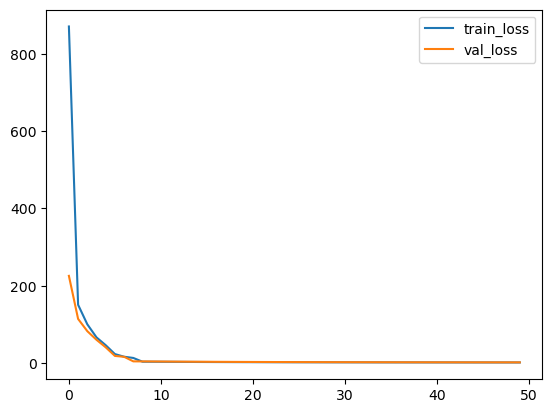

In [213]:
# plot loss performance
_ = log.plot()
plt.show()

#### Prediction

In [240]:
# get X from test data
test_ct_X = [item[0] for item in test_ct_data]
dl_test_x = DataLoader(test_ct_X, batch_size, shuffle=False)
next(iter(dl_test_x)).shape

torch.Size([50, 1, 20, 50, 50])

In [241]:
# get prediction
surv = model.predict_surv_df(dl_test_x)

In [244]:
# Evaluation
surv_cdi = model.interpolate(10).predict_surv_df(dl_test_x)
surv_chi = model.interpolate(10, 'const_hazard').predict_surv_df(dl_test_x)
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')

In [245]:
ev_cdi.concordance_td(), ev_chi.concordance_td()

(0.500924784217016, 0.500924784217016)

(0.2477434439294755, 0.24827778524493807)

<AxesSubplot:>

<AxesSubplot:>

Text(0, 0.5, 'Brier score')

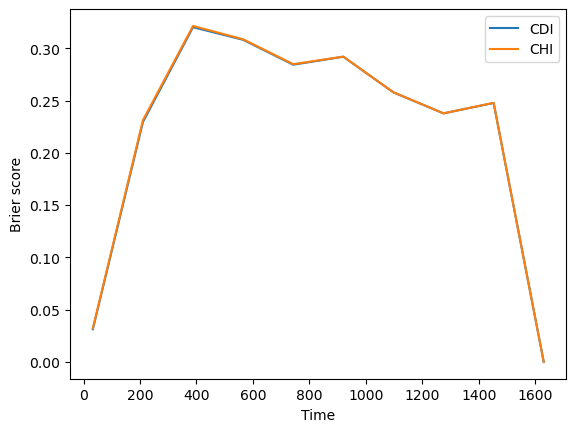

In [246]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 10)
ev_cdi.integrated_brier_score(time_grid), ev_chi.integrated_brier_score(time_grid)

ev_cdi.brier_score(time_grid).rename('CDI').plot()
ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
plt.show()

### Q2. Hybird NN model with radi feature and 3D CT_img

In [288]:
# load radiomics data
data_radi = pd.read_csv('/Users/peAce/Box/DSexam/Lung1_data/lung1_radiomics.csv')
data_radi['ID']  = data_radi['PatientID'].str[-3:]
del data_radi['PatientID']
data_radi.set_index('ID', inplace=True)
# sort data to align with ct_img
data_radi.sort_index(inplace=True)

# split train test
train_data_radi = data_radi.merge(train_id, how='inner', left_index=True, right_index=True)
train_data_radi.sort_index(inplace=True) # sort data to align with ct_img
del train_data_radi['Train_ID']
test_data_radi = data_radi.merge(test_id, how='inner', left_index=True, right_index=True)
test_data_radi.sort_index(inplace=True)
del test_data_radi['Test_ID']

In [279]:
# quick overview - check na column
data_radi.info()
list(data_radi.columns)
data_radi.iloc[0:5,0:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Columns: 798 entries, PatientID to Strength.wavelet.LLL
dtypes: float64(793), int64(4), object(1)
memory usage: 2.4+ MB


['PatientID',
 'Elongation.original',
 'Flatness.original',
 'LeastAxisLength.original',
 'MajorAxisLength.original',
 'Maximum2DDiameterColumn.original',
 'Maximum2DDiameterRow.original',
 'Maximum2DDiameterSlice.original',
 'Maximum3DDiameter.original',
 'MeshVolume.original',
 'MinorAxisLength.original',
 'Sphericity.original',
 'SurfaceArea.original',
 'SurfaceVolumeRatio.original',
 'VoxelVolume.original',
 '10Percentile.original',
 '90Percentile.original',
 'Energy.original',
 'Entropy.original',
 'InterquartileRange.original',
 'Kurtosis.original',
 'Maximum.original',
 'MeanAbsoluteDeviation.original',
 'Mean.original',
 'Median.original',
 'Minimum.original',
 'Range.original',
 'RobustMeanAbsoluteDeviation.original',
 'RootMeanSquared.original',
 'Skewness.original',
 'TotalEnergy.original',
 'Uniformity.original',
 'Variance.original',
 'Autocorrelation.original',
 'ClusterProminence.original',
 'ClusterShade.original',
 'ClusterTendency.original',
 'Contrast.original',
 'Co

In [276]:
# dummies or not? - no
data_radi.select_dtypes('int64').head()

,Energy.original,Maximum.original,Minimum.original,Range.original
0,2426653817,1040,-1021,2061
1,7280392250,575,-1024,1599
2,854504320,230,-909,1139
3,866521876,607,-994,1601
4,1014806238,2621,-1024,3645


##### RF model for feature selection

In [290]:
# y for RF
RF_y_train_time = train_data['Survival.time'].values
RF_y_train_event = train_data['deadstatus.event'].values
RF_y_test_time = test_data['Survival.time'].values
RF_y_test_event = test_data['deadstatus.event'].values

In [322]:
# RF event
# grid serach for best parameters
n_estimators = [int(x) for x in np.linspace(200, 500, 11)]
max_features = ['auto', 'log2', 50]
max_depths = [int(x) for x in np.linspace(20, 100, 11)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depths}

rf_event = RandomForestClassifier()
rf_event_search = RandomizedSearchCV(estimator = rf_event, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, 
                               verbose=2, 
                               random_state=101, 
                               n_jobs = -1)
rf_event_search.fit(train_data_radi, RF_y_train_event)
rf_event_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [20, 28, 36, 44, 52, 60,
                                                      68, 76, 84, 92, 100],
                                        'max_features': ['auto', 'log2', 50],
                                        'n_estimators': [200, 230, 260, 290,
                                                         320, 350, 380, 410,
                                                         440, 470, 500]},
                   random_state=101, verbose=2)

{'n_estimators': 410, 'max_features': 50, 'max_depth': 44}

In [323]:
# RF-event fit best RF and get most significant features
rf_event = RandomForestClassifier(n_estimators=410, 
                                  max_features=50, 
                                  max_depth=44, n_jobs = -1)
rf_event.fit(train_data_radi, RF_y_train_event)

RandomForestClassifier(max_depth=44, max_features=50, n_estimators=410,
                       n_jobs=-1)

In [324]:
# Eval
rf_event_pred = rf_event.predict(test_data_radi)
print(confusion_matrix(RF_y_test_event,rf_event_pred))
print(classification_report(RF_y_test_event,rf_event_pred))

[[16 24]
 [14 42]]
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        40
           1       0.64      0.75      0.69        56

    accuracy                           0.60        96
   macro avg       0.58      0.57      0.57        96
weighted avg       0.59      0.60      0.59        96



In [ ]:
# feature importance
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_data_radi.columns, rf_event.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)
plt.show()


In [ ]:
importances.sort_values(by='Gini-importance', ascending=False, inplace=True)
importances.head(20)
event_impt_list = importances.head(20).index.tolist()
event_impt_list

<Figure size 792x360 with 0 Axes>

<AxesSubplot:>

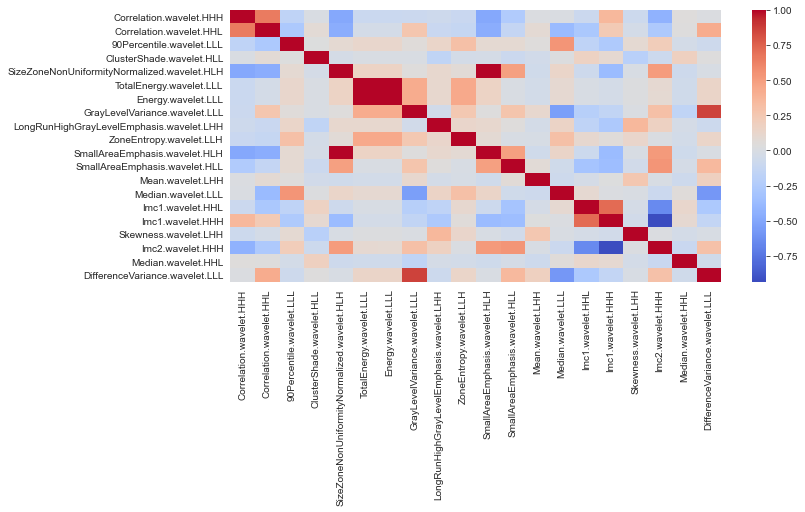

In [445]:
# plot corr 
plt.figure(figsize=(11,5))
corr_check = data_radi[event_impt_list].corr()
sns.heatmap(corr_check, cmap="coolwarm",annot=False)
corr_check.to_excel('corr_check_event.xlsx')

In [465]:
# Remove high correlated columns and refit
event_impt_list_refine = [item for item in event_impt_list if item not in ['Imc2.wavelet.HHH',
'Imc2.wavelet.HHH',
'Imc1.wavelet.HHH',
'DifferenceVariance.wavelet.LLL',
'SmallAreaEmphasis.wavelet.HLH',
'Energy.wavelet.LLL']]

# grid serach for best parameters
x = train_data_radi[event_impt_list_refine]
n_estimators = [int(x) for x in np.linspace(200, 500, 11)]
max_features = ['sqrt','log2',15]
max_depths = [int(x) for x in np.linspace(20, 100, 11)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depths}

rf_event = RandomForestClassifier()
rf_event_search = RandomizedSearchCV(estimator = rf_event, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, 
                               verbose=2, 
                               random_state=101, 
                               n_jobs = -1)
rf_event_search.fit(x, RF_y_train_event)
rf_event_search.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [20, 28, 36, 44, 52, 60,
                                                      68, 76, 84, 92, 100],
                                        'max_features': ['sqrt', 'log2', 15],
                                        'n_estimators': [200, 230, 260, 290,
                                                         320, 350, 380, 410,
                                                         440, 470, 500]},
                   random_state=101, verbose=2)

{'n_estimators': 380, 'max_features': 'log2', 'max_depth': 68}

In [466]:
# RF-event with refined features
x = train_data_radi[event_impt_list_refine]
rf_event = RandomForestClassifier(n_estimators=380, 
                                  max_features='log2', 
                                  max_depth=68, n_jobs = -1)
rf_event.fit(x, RF_y_train_event)

# Eval
x = test_data_radi[event_impt_list_refine]
rf_event_pred = rf_event.predict(x)
print(confusion_matrix(RF_y_test_event,rf_event_pred))
print(classification_report(RF_y_test_event,rf_event_pred))

RandomForestClassifier(max_depth=68, max_features='log2', n_estimators=380,
                       n_jobs=-1)

[[15 25]
 [11 45]]
              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.64      0.80      0.71        56

    accuracy                           0.62        96
   macro avg       0.61      0.59      0.58        96
weighted avg       0.62      0.62      0.61        96



In [331]:
# RF survival time
# grid serach for best parameters
n_estimators = [int(x) for x in np.linspace(200, 500, 11)]
criterion = ['poisson']
max_features = ['auto', 'log2', 50]
max_depths = [int(x) for x in np.linspace(20, 100, 11)]

random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depths}

rf_time = RandomForestRegressor()
rf_time_search = RandomizedSearchCV(estimator = rf_time, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, 
                               verbose=2, 
                               random_state=101, 
                               n_jobs = -1)
rf_time_search.fit(train_data_radi, RF_y_train_time)
rf_time_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['poisson'],
                                        'max_depth': [20, 28, 36, 44, 52, 60,
                                                      68, 76, 84, 92, 100],
                                        'max_features': ['auto', 'log2', 50],
                                        'n_estimators': [200, 230, 260, 290,
                                                         320, 350, 380, 410,
                                                         440, 470, 500]},
                   random_state=101, verbose=2)

{'n_estimators': 320,
 'max_features': 'log2',
 'max_depth': 20,
 'criterion': 'poisson'}

In [332]:
# RF-time fit best RF and get most significant features
rf_time = RandomForestRegressor(n_estimators=320, 
                                  max_features='log2', 
                                  max_depth=20, 
                                  criterion='poisson',n_jobs = -1)
rf_time.fit(train_data_radi, RF_y_train_time)

RandomForestRegressor(criterion='poisson', max_depth=20, max_features='log2',
                      n_estimators=320, n_jobs=-1)

In [336]:
# Eval  
rf_time_pred = rf_time.predict(test_data_radi)
mse = mean_squared_error(RF_y_test_time, rf_time_pred)
rmse = math.sqrt(mse)
print(rmse) 

376.22421026941623


In [348]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_data_radi.columns, rf_time.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances_time = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

importances_time.sort_values(by='Gini-importance', ascending=False, inplace=True)
importances_time.head(20)
time_impt_list = importances_time.head(20).index.tolist()

,Gini-importance
ClusterShade.wavelet.HLH,0.007769
Mean.wavelet.LLH,0.006955
ZoneEntropy.wavelet.LLL,0.006370
Sphericity.original,0.006133
ClusterShade.wavelet.HHL,0.005936
DependenceEntropy.wavelet.LLL,0.005705
ZoneEntropy.wavelet.LHL,0.005449
DependenceNonUniformityNormalized.wavelet.HHH,0.005315
Skewness.wavelet.HHL,0.005187
JointEnergy.wavelet.LLH,0.004861


<Figure size 792x360 with 0 Axes>

<AxesSubplot:>

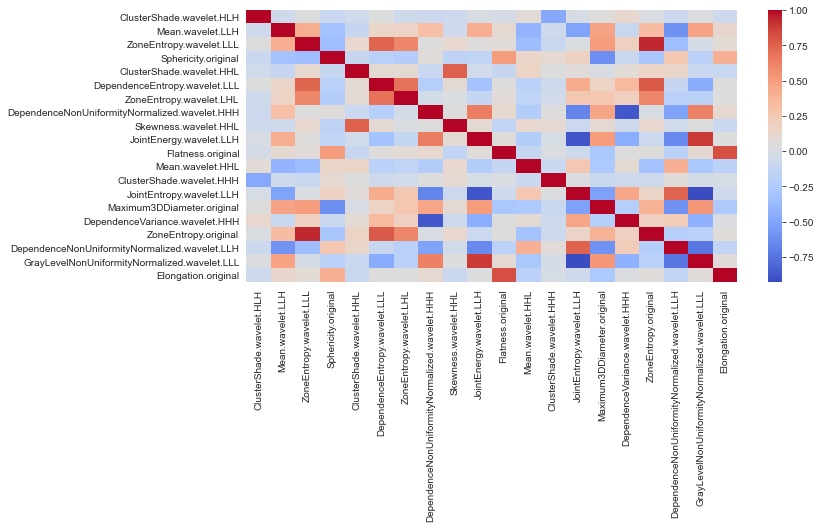

In [456]:
# plot corr 
plt.figure(figsize=(11,5))
corr_check = data_radi[time_impt_list].corr()
sns.heatmap(corr_check, cmap="coolwarm",annot=False)
corr_check.to_excel('corr_check_time.xlsx')

In [458]:
# Remove high correlated columns and refit
time_impt_list_refine = ['ClusterShade.wavelet.HLH', 'Mean.wavelet.LLH','ZoneEntropy.wavelet.LLL','Sphericity.original',
'ClusterShade.wavelet.HHL','DependenceEntropy.wavelet.LLL','DependenceNonUniformityNormalized.wavelet.HHH',
'JointEnergy.wavelet.LLH','Flatness.original']
x = train_data_radi[time_impt_list_refine]
n_estimators = [int(x) for x in np.linspace(200, 500, 11)]
criterion = ['poisson']
max_features = [9]
max_depths = [int(x) for x in np.linspace(20, 100, 11)]

random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depths}

rf_time = RandomForestRegressor()
rf_time_search = RandomizedSearchCV(estimator = rf_time, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, 
                               verbose=2, 
                               random_state=101, 
                               n_jobs = -1)
rf_time_search.fit(x, RF_y_train_time)
rf_time_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['poisson'],
                                        'max_depth': [20, 28, 36, 44, 52, 60,
                                                      68, 76, 84, 92, 100],
                                        'max_features': [9],
                                        'n_estimators': [200, 230, 260, 290,
                                                         320, 350, 380, 410,
                                                         440, 470, 500]},
                   random_state=101, verbose=2)

{'n_estimators': 230,
 'max_features': 9,
 'max_depth': 20,
 'criterion': 'poisson'}

In [460]:
# RF-time fit with refined columns
x = train_data_radi[time_impt_list_refine]
rf_time = RandomForestRegressor(n_estimators=230, 
                                  max_features=9, 
                                  max_depth=20, 
                                  criterion='poisson',n_jobs = -1)
rf_time.fit(train_data_radi, RF_y_train_time)
# Eval  
x = test_data_radi[time_impt_list_refine]
rf_time_pred = rf_time.predict(test_data_radi)
mse = mean_squared_error(RF_y_test_time, rf_time_pred)
rmse = math.sqrt(mse)
print(rmse) 

RandomForestRegressor(criterion='poisson', max_depth=20, max_features=9,
                      n_estimators=230, n_jobs=-1)

377.68543562811055


<Figure size 792x360 with 0 Axes>

<AxesSubplot:>

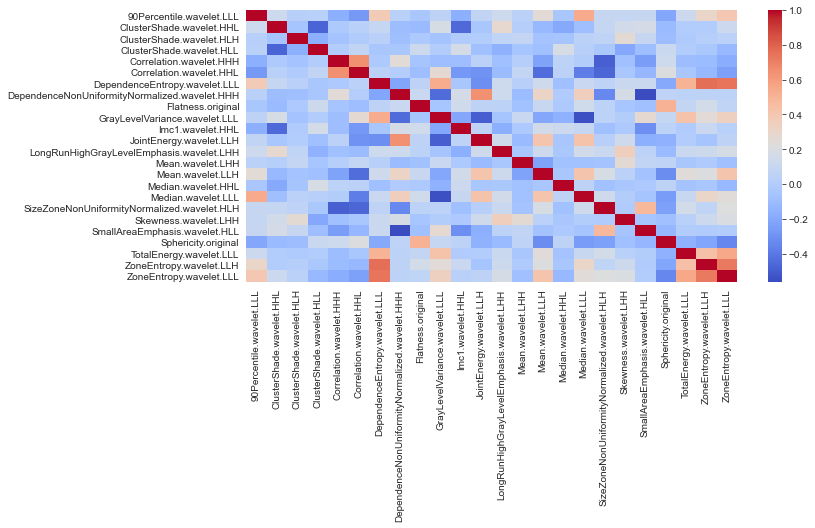

In [469]:
# correlation quick check
radi_impt_list = np.union1d(event_impt_list_refine, time_impt_list_refine).tolist()
plt.figure(figsize=(11,5))
sns.heatmap(data_radi[radi_impt_list].corr(), cmap="coolwarm",annot=False)

#### Hybrid NN model with CT_img and important radi features

In [472]:
# combine important columns
radi_impt_list = np.union1d(event_impt_list_refine, time_impt_list_refine).tolist()

In [520]:
# normalize important radi features
scaler = MinMaxScaler()
radi_train_normlize = torch.from_numpy(scaler.fit_transform(train_data_radi[radi_impt_list]).astype(np.float32))
radi_test_normlize = torch.from_numpy(scaler.transform(test_data_radi[radi_impt_list]).astype(np.float32))

In [517]:
# get X from ct_img data
train_ct_data_x = [item[0] for item in train_ct_data]
train_ct_data_x = torch.stack(train_ct_data_x, dim=0)
train_ct_data_x.shape

test_ct_data_x = [item[0] for item in test_ct_data]
test_ct_data_x = torch.stack(test_ct_data_x, dim=0)
test_ct_data_x.shape

torch.Size([292, 1, 20, 50, 50])

In [634]:
# Train / Test data for hybrid net
train_all_x = []
for i in range(len(train_ct_data_x)):
    item1 = train_ct_data_x[i]
    item2 = radi_train_normlize[i]
    item3 = train_ct_data[i][1]
    
    train_all_x.append(((item1, item2), item3))
    
train_all_x = DataLoader(train_all_x, batch_size, shuffle=True, collate_fn=collate_fn)

In [665]:
test_all_x = []
for i in range(len(test_ct_data_x)):
    item1 = test_ct_data_x[i]
    item2 = radi_test_normlize[i]
    item3 = test_ct_data[i][1]
    
    test_all_x.append(((item1, item2), item3))
    
test_all_x = DataLoader(test_all_x, batch_size, shuffle=False, collate_fn=collate_fn)

In [637]:
# quick check
batch_x = next(iter(train_all_x))
batch_x.shapes()
batch_x.dtypes()

((torch.Size([50, 1, 20, 50, 50]), torch.Size([50, 24])),
 (torch.Size([50]), torch.Size([50])))

((torch.float32, torch.float32), (torch.int64, torch.float32))

In [642]:
# Net - img
class MyNet_img(nn.Module):
    def __init__(self):
        super(MyNet_img, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, 1)
        self.max_pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(64, 32)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Net - radi
class MyNet_radi(nn.Module):
    def __init__(self):
        super(MyNet_radi, self).__init__()
        self.fc1 = nn.Linear(24, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Net - ensemble
class MyEnsemble(nn.Module):
    def __init__(self, Net_img, Net_radi, out_features):
        super(MyEnsemble, self).__init__()
        self.Net_img = Net_img
        self.Net_radi = Net_radi
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, out_features)
        
    def forward(self, x1, x2):
        x1 = self.Net_img(x1)
        x2 = self.Net_radi(x2)
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [643]:
# Ensemble
Net_img = MyNet_img()
Net_radi = MyNet_radi()
model_all = MyEnsemble(Net_img, Net_radi, labtrans.out_features)

model_all

MyEnsemble(
  (Net_img): MyNet_img(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (max_pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (glob_avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
    (fc1): Linear(in_features=64, out_features=32, bias=True)
  )
  (Net_radi): MyNet_radi(
    (fc1): Linear(in_features=24, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

In [652]:
# Logistic-Hazard Model
model_hybrid = LogisticHazard(model_all, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Training
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log_hybrid = model_hybrid.fit_dataloader(train_all_x, epochs, callbacks, verbose, val_dataloader=test_all_x)

# Save the whole network
model_hybrid.save_net('Q2_hybrid_net.pt')

0:	[49s / 49s],		train_loss: 980.6741,	val_loss: 138.9058
1:	[50s / 1m:39s],		train_loss: 93.0914,	val_loss: 47.2410
2:	[49s / 2m:29s],		train_loss: 31.0079,	val_loss: 13.8010
3:	[48s / 3m:17s],		train_loss: 8.3057,	val_loss: 4.2198
4:	[48s / 4m:6s],		train_loss: 3.5096,	val_loss: 5.0585
5:	[48s / 4m:55s],		train_loss: 4.3974,	val_loss: 4.5660
6:	[49s / 5m:45s],		train_loss: 3.7238,	val_loss: 4.4612
7:	[53s / 6m:39s],		train_loss: 3.6246,	val_loss: 4.3292
8:	[49s / 7m:28s],		train_loss: 3.5082,	val_loss: 4.1922
9:	[48s / 8m:17s],		train_loss: 3.3987,	val_loss: 4.0580
10:	[49s / 9m:7s],		train_loss: 3.3014,	val_loss: 3.9296
11:	[51s / 9m:58s],		train_loss: 3.1851,	val_loss: 3.8052
12:	[48s / 10m:47s],		train_loss: 3.0946,	val_loss: 3.6899
13:	[49s / 11m:36s],		train_loss: 3.0043,	val_loss: 3.5843
14:	[48s / 12m:25s],		train_loss: 2.9276,	val_loss: 3.4849
15:	[49s / 13m:15s],		train_loss: 2.8552,	val_loss: 3.3922
16:	[49s / 14m:4s],		train_loss: 2.7793,	val_loss: 3.3056
17:	[48s / 14m:53

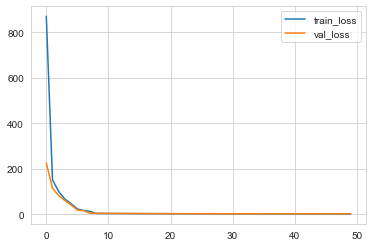

In [654]:
_ = log.plot()

#### Prediction

In [658]:
# get X from test data
test_all_onlyx = []
for i in range(len(test_ct_data_x)):
    item1 = test_ct_data_x[i]
    item2 = radi_test_normlize[i]

    test_all_onlyx.append((item1, item2))
    
test_all_onlyx = DataLoader(test_all_onlyx, batch_size, shuffle=False, collate_fn=collate_fn)

In [668]:
# get prediction
surv_hybrid = model_hybrid.predict_surv_df(test_all_onlyx)

/Users/peAce/opt/anaconda3/lib/python3.8/site-packages/torchtuples/base.py:482: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  warnings.warn(


In [669]:
# Evaluation
surv_cdi = model_hybrid.interpolate(10).predict_surv_df(test_all_onlyx)
surv_chi = model_hybrid.interpolate(10, 'const_hazard').predict_surv_df(test_all_onlyx)
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')
ev_cdi.concordance_td(), ev_chi.concordance_td()

(0.500924784217016, 0.500924784217016)

(0.24194443913153832, 0.24244595693937246)

<AxesSubplot:>

<AxesSubplot:>

Text(0, 0.5, 'Brier score')

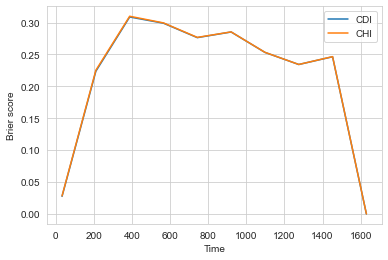

In [670]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 10)
ev_cdi.integrated_brier_score(time_grid), ev_chi.integrated_brier_score(time_grid)

ev_cdi.brier_score(time_grid).rename('CDI').plot()
ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
plt.show()

#### Archive

In [ ]:
# Get columns
col_name = data_radi.columns.tolist()
end_list =['original', 'HHH', 'HHL', 'HLH', 'HLL', 'LHH', 'LHL', 'LLH', 'LLL']
col_list = pd.DataFrame()
for item in end_list:
    temp_list = pd.DataFrame({item: sorted([name for name in col_name if item in name])})
    col_list = pd.concat([col_list,temp_list], axis=1, ignore_index = True)

col_list.columns = end_list

In [430]:
# Check importance among orignal measurement
# RF-event, original
x = train_data_radi[[name for name in col_name if 'original' in name]]
rf_event = RandomForestClassifier(n_estimators=410, 
                                  max_features=50, 
                                  max_depth=44, n_jobs = -1)
rf_event.fit(x, RF_y_train_event)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rf_event.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False, inplace=True)
importances.head(20)


RandomForestClassifier(max_depth=44, max_features=50, n_estimators=410,
                       n_jobs=-1)

,Gini-importance
90Percentile.original,0.037312
Energy.original,0.031206
Median.original,0.029354
DifferenceVariance.original,0.028094
TotalEnergy.original,0.026438
Flatness.original,0.025316
Sphericity.original,0.021514
LowGrayLevelZoneEmphasis.original,0.019867
LargeDependenceLowGrayLevelEmphasis.original,0.019120
Imc1.original,0.018540


In [432]:
# RF-event, not original
x = train_data_radi[[name for name in col_name if 'original' not in name]]
rf_event = RandomForestClassifier(n_estimators=410, 
                                  max_features=50, 
                                  max_depth=44, n_jobs = -1)
rf_event.fit(x, RF_y_train_event)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rf_event.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False, inplace=True)
importances.head(20)

RandomForestClassifier(max_depth=44, max_features=50, n_estimators=410,
                       n_jobs=-1)

,Gini-importance
Correlation.wavelet.HHH,0.010738
Correlation.wavelet.HHL,0.006985
90Percentile.wavelet.LLL,0.006857
ClusterShade.wavelet.HLL,0.005614
SizeZoneNonUniformityNormalized.wavelet.HLH,0.005475
TotalEnergy.wavelet.LLL,0.004758
Energy.wavelet.LLL,0.004576
GrayLevelVariance.wavelet.LLL,0.004366
LongRunHighGrayLevelEmphasis.wavelet.LHH,0.004302
ZoneEntropy.wavelet.LLH,0.004300


In [ ]:
plt.figure(figsize=(11,5))
x = train_data_radi[[name for name in col_name if '90Percentile.' in name]].corr()
sns.heatmap(x, cmap="coolwarm",annot=True)

In [ ]:
plt.figure(figsize=(11,5))
x = train_data_radi[[name for name in col_name if 'ZoneEntropy.' in name]].corr()
sns.heatmap(x, cmap="coolwarm",annot=True)

(torch.Size([50, 1, 20, 50, 50]), (torch.Size([50]), torch.Size([50])))

(torch.float32, (torch.int64, torch.float32))

In [671]:
data_radi.shape

(388, 797)